In [1]:
import glob
import numpy as np
import matplotlib.pyplot as plt
import torch
import math
from scipy import stats
from math import sqrt

In [2]:
def parse_boat_results(boat_res_file):
    
    num_lines = sum(1 for line in open(boat_res_file))
    
    boat_result = np.zeros([num_lines, 3])
    
    with open(boat_res_file) as boat_f:
        for line_cnt, line in enumerate(boat_f):
            for el_cnt, arr_el in enumerate(line.strip().split(",")):
                if el_cnt < 3:
                    boat_result[line_cnt, el_cnt] = float(arr_el.split("=")[1])
    
    return boat_result

def find_best_solution(xmins, target_lms):
    closest_dist = np.inf
    closest_point = None
    
    for xmin in xmins:
        for bh_lm in target_lms:
            dist = torch.dist(xmin, bh_lm).numpy()
            if dist < closest_dist: 
                closest_dist = dist
                closest_point = xmin
                
    return closest_point, closest_dist

def analyse_performance(points):
    
    no_tests = len(points)
    no_steps = len(points[no_tests-1])
    perform_stats = np.zeros([no_steps, 6], dtype=np.float32)
    
    # For each step calculate statistics for euclidean distance to the closest minima
    
    for i in range(no_steps):
        dist_arr = np.zeros(no_tests, dtype=np.float32)
   
        for j in range(no_tests):
            point = torch.tensor([points[j][i][0], points[j][i][1]])
            dist = find_best_solution([point], branin_hoo_lms)
            dist_arr[j] = dist[1]

        dist_stats = stats.describe(dist_arr)
        
        perform_stats[i][0] = i
        perform_stats[i][1] = dist_stats.mean
        perform_stats[i][2] = sqrt(dist_stats.variance)
        perform_stats[i][3] = dist_stats.minmax[0]
        perform_stats[i][4] = dist_stats.minmax[1]
        
        if i == 0:
            perform_stats[i][5] = dist_stats.mean
        else:
            perform_stats[i][5] = min(perform_stats[i-1][5], dist_stats.mean)
        
    return perform_stats

In [3]:
branin_hoo_lms = torch.stack(
    (torch.tensor([-math.pi, math.pi, 9.42478]), 
     torch.tensor([12.275, 2.275, 2.475])), dim=1)

In [4]:
boat_res_files = glob.glob("boat_results/struct_*.out")

boat_results = []

for boat_res_file in boat_res_files:
    boat_results.append(parse_boat_results(boat_res_file))

boat_perf_stats_sbo = analyse_performance(boat_results)

In [6]:
boat_res_files = glob.glob("boat_results/bo_*.out")

boat_results = []

for boat_res_file in boat_res_files:
    boat_results.append(parse_boat_results(boat_res_file))

boat_perf_stats_bo = analyse_performance(boat_results);

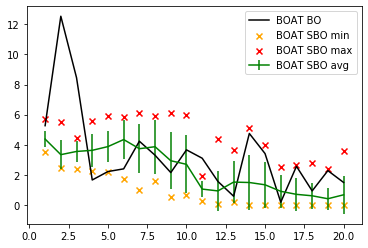

In [7]:
plt.figure()

plt.scatter(boat_perf_stats_sbo[:, 0]+1, boat_perf_stats_sbo[:, 3], color='orange', marker='x', label='BOAT SBO min')
plt.scatter(boat_perf_stats_sbo[:, 0]+1, boat_perf_stats_sbo[:, 4], color='r', marker='x', label='BOAT SBO max')
plt.errorbar(boat_perf_stats_sbo[:, 0]+1, boat_perf_stats_sbo[:, 1], boat_perf_stats_sbo[:, 2], color='g', label='BOAT SBO avg')

plt.plot(boat_perf_stats_bo[:20, 0]+1, boat_perf_stats_bo[:20, 1], color='black', label='BOAT BO')

plt.legend();

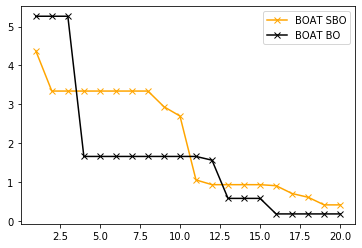

# Parsing Pyro results

In [47]:
def parse_pyro_results(pyro_res_file):
    return np.loadtxt(pyro_res_file, delimiter=',')

In [48]:
pyro_res_files = glob.glob("pyro_results_backup/pyro_bo_*.out")

pyro_bo_results = []

for pyro_res_file in pyro_res_files:
    pyro_bo_results.append(parse_pyro_results(pyro_res_file))


In [49]:
pyro_perf_stats_bo = analyse_performance(pyro_bo_results);

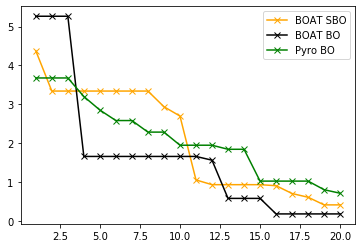

In [51]:
plt.figure()

plt.plot(boat_perf_stats_sbo[:, 0]+1, boat_perf_stats_sbo[:, 5], color='orange', marker='x', label='BOAT SBO')

plt.plot(boat_perf_stats_bo[:20, 0]+1, boat_perf_stats_bo[:20, 5], color='black', marker='x', label='BOAT BO')

plt.plot(pyro_perf_stats_bo[:20, 0]+1, pyro_perf_stats_bo[:20, 5], color='green', marker='x', label='Pyro BO')

plt.legend();